In [40]:
from pandas import Series, DataFrame
import pandas as pd


%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [41]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

Convert date time type to seperate the train and test set. becasue the test set data time have to be come later than the train set

In [42]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

pick random 10000 users row as our train data set

In [43]:
import random

unique_users = train.user_id.unique()

sel_user_ids = [unique_users[i] for i in sorted(random.sample(range(len(unique_users)), 10000)) ]
sel_train = train[train.user_id.isin(sel_user_ids)]
print len(sel_train)

319807


In [44]:
t1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]
t2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]

In [45]:
# remove the empty bookinf in test set
t2 = t2[t2.is_booking == True]


# Simple predication: use the most 5 common cluster as predication for each data in test

In [46]:
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)

In [47]:
predictions = [most_common_clusters for i in range(t2.shape[0])]

# Too many features in destination --> use PCA to reduce dimension

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = destinations["srch_destination_id"]

# Generating feature

convert the time data into float that can be used as predicator in random forest.
and join the destination feature transformed by PCA

In [49]:
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

df = calc_fast_features(t1)

df.fillna(-1, inplace=True)

/Users/yaweny2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/yaweny2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/yaweny2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [50]:
df[:5]

,channel,ci_day,ci_dayofweek,ci_month,ci_quarter,cnt,co_day,co_dayofweek,co_month,co_quarter,...,srch_rm_cnt,stay_span,user_id,user_location_city,user_location_country,user_location_region,year,0,1,2
5768,1,15.0,4.0,2.0,1.0,1,17.0,6.0,2.0,1.0,...,1,48.0,34019,12328,205,354,2013,-1.212365,-1.065999,-0.000302
5769,1,8.0,4.0,3.0,1.0,1,10.0,6.0,3.0,1.0,...,1,48.0,34019,12328,205,354,2013,-0.626661,0.214322,0.011202
5770,1,22.0,4.0,3.0,1.0,2,24.0,6.0,3.0,1.0,...,1,48.0,34019,12328,205,354,2013,0.143469,0.103292,0.118912
5771,1,22.0,4.0,3.0,1.0,2,24.0,6.0,3.0,1.0,...,1,48.0,34019,12328,205,354,2013,0.143469,0.103292,0.118912
5772,1,22.0,4.0,3.0,1.0,1,24.0,6.0,3.0,1.0,...,1,48.0,34019,12328,205,354,2013,0.143469,0.103292,0.118912


In [51]:
predictors = [c for c in df.columns if c not in ["hotel_cluster"]]
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_validation.cross_val_score(clf, df[predictors], df['hotel_cluster'], cv=3)
scores

array([ 0.06471449,  0.06494025,  0.06663115])

# Top clusters based on hotel_cluster

In [52]:
def make_key(items):
    return "_".join([str(i) for i in items])

match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = t1.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

In [53]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top

# Transform this dictionary to find the top 5 hotel clusters for each srch_destination_id

In [54]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top

# Making predictions based on destination

In [55]:
preds = []
for index, row in t2.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])

In [56]:
preds

[[56, 70, 98, 41, 55],
 [1, 79, 45, 54, 24],
 [],
 [25, 18, 37, 89, 72],
 [28, 31, 50, 32, 7],
 [33, 25, 40, 59, 98],
 [10, 49, 4, 28, 59],
 [17, 31, 90, 91, 73],
 [4, 49, 23, 13, 19],
 [0, 26, 34, 17, 96],
 [36, 63, 86, 44, 57],
 [],
 [9, 68, 98, 37, 95],
 [70, 83, 17, 41, 77],
 [],
 [71, 34, 77, 18, 50],
 [64, 37, 21, 59, 11],
 [36, 30, 99, 15, 58],
 [64, 37, 21, 59, 11],
 [91],
 [56, 70, 98, 41, 55],
 [50, 9, 21, 70, 49],
 [2, 18, 25, 4, 5],
 [21, 98, 77, 40, 37],
 [21, 98, 77, 40, 37],
 [72, 48, 32, 40, 18],
 [18, 68, 59, 6, 55],
 [19, 21, 9, 17, 23],
 [1, 79, 45, 24, 51],
 [1, 79, 45, 24, 51],
 [1, 79, 45, 54, 24],
 [96, 15, 13, 32, 7],
 [91, 95],
 [],
 [],
 [8, 64, 22, 5, 2],
 [],
 [],
 [83, 41, 17, 70, 5],
 [90, 84, 0, 53, 93],
 [91, 48, 62],
 [],
 [],
 [],
 [18, 99, 95, 42, 91],
 [96, 69, 9, 37, 32],
 [91, 59, 48, 50, 69],
 [],
 [70, 98, 91, 69, 41],
 [29, 64, 46, 97, 62],
 [56, 41, 70, 55, 98],
 [71, 34, 77, 18, 50],
 [97, 98, 21, 25, 11],
 [],
 [71, 34, 77, 18, 50],
 [13, 7, 

In [57]:
df_cali = df.loc[df["user_location_region"] == 174]
df_cali.columns

Index([                  u'channel',                    u'ci_day',
                    u'ci_dayofweek',                  u'ci_month',
                      u'ci_quarter',                       u'cnt',
                          u'co_day',              u'co_dayofweek',
                        u'co_month',                u'co_quarter',
                             u'day',                 u'dayofweek',
                   u'hotel_cluster',           u'hotel_continent',
                   u'hotel_country',              u'hotel_market',
                            u'hour',                u'is_booking',
                       u'is_mobile',                u'is_package',
                          u'minute',                     u'month',
       u'orig_destination_distance',            u'posa_continent',
                         u'quarter',                 u'site_name',
                 u'srch_adults_cnt',         u'srch_children_cnt',
             u'srch_destination_id',  u'srch_destination_type_

This Kmeans exploration helped us get a sense of the 3 types of users in california region based on each user's hotel country and hotel market.

/Users/yaweny2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


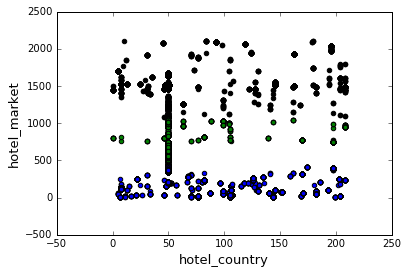

In [37]:
from sklearn.cluster import KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_cali[['hotel_country', 'hotel_market']])
df_cali['cluster'] = kmeans.labels_

def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['hotel_country'], clustered_df['hotel_market'], c=colors[n-1])
        plt.xlabel('hotel_country', fontsize=13)
        plt.ylabel('hotel_market', fontsize=13)


visualize_clusters(df_cali, num_clusters)

It seems for the California users, users in different clusters have different preference in hotel market. Maybe some people are richer than others, and they prefer better stars hotel.